In [2]:
!pip install tiktoken

In [3]:
import torch
import torch.nn as nn
import tiktoken

In [4]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads) == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer(
            "mask",
            torch.tril(torch.ones(context_length, context_length)))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2,3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(~mask_bool, -torch.inf)

        attn_weights = torch.softmax(
                attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1,2)
        context_vec = context_vec.contiguous().view(
                b, num_tokens, self.d_out
            )
        context_vec = self.out_proj(context_vec)
        return context_vec

class LayerNorm(nn.Module):
 def __init__(self, emb_dim):
  super().__init__()
  self.eps = 1e-6
  self.scale = nn.Parameter(torch.ones(emb_dim))
  self.shift = nn.Parameter(torch.zeros(emb_dim))

 def forward(self, x):
  mean = x.mean(dim=-1, keepdim=True)
  var = x.var(dim=-1, keepdim=True, unbiased=False)
  norm_x = (x - mean) / torch.sqrt(var + self.eps)
  return self.scale * norm_x + self.shift

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
    nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
    nn.GELU(),
    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )
  def forward(self, x):
    return self.layers(x)

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
    d_in=cfg["emb_dim"],
    d_out=cfg["emb_dim"],
    context_length=cfg["context_length"],
    num_heads=cfg["n_heads"],
    dropout=cfg["drop_rate"],
    qkv_bias=cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

class GPTModel(nn.Module):
 def __init__(self, cfg):
  super().__init__()
  self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
  self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
  self.drop_emb = nn.Dropout(cfg["drop_rate"])

  self.trf_blocks = nn.Sequential(
  *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

  self.final_norm = LayerNorm(cfg["emb_dim"])
  self.out_head = nn.Linear(
  cfg["emb_dim"], cfg["vocab_size"], bias=False
  )
 def forward(self, in_idx):
  batch_size, seq_len = in_idx.shape
  tok_embeds = self.tok_emb(in_idx)

  pos_embeds = self.pos_emb(
  torch.arange(seq_len, device=in_idx.device)
  )
  x = tok_embeds + pos_embeds
  x = self.drop_emb(x)
  x = self.trf_blocks(x)
  x = self.final_norm(x)
  logits = self.out_head(x)
  return logits

In [6]:
model = GPTModel(GPT_CONFIG_124M)
batch = torch.randint(0, GPT_CONFIG_124M["vocab_size"], (2, GPT_CONFIG_124M["context_length"]))
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[ 3397, 40754, 26433,  ..., 35345, 40953, 24547],
        [34307, 49980, 24558,  ..., 29291, 23668, 40982]])

Output shape: torch.Size([2, 1024, 50257])
tensor([[[-4.4988e-01,  3.7144e-01, -2.6064e-01,  ...,  4.6247e-01,
          -8.3105e-01,  6.2966e-02],
         [-4.4622e-01, -5.5609e-01, -1.4426e-01,  ..., -5.6610e-01,
           2.4956e-02,  5.0456e-01],
         [-7.3955e-01, -6.8164e-02, -6.2195e-01,  ...,  1.1588e+00,
          -2.7165e-01,  6.1499e-01],
         ...,
         [ 5.3372e-01, -3.7606e-01,  3.3681e-01,  ..., -3.8556e-01,
          -1.1487e+00, -9.2615e-01],
         [ 1.9850e-01, -6.9179e-01, -1.0179e+00,  ...,  6.7727e-01,
           3.5975e-01, -1.8631e-01],
         [-6.3795e-02, -2.6473e-01, -5.2965e-02,  ...,  4.1374e-01,
           3.4266e-01,  3.7704e-01]],

        [[-1.1963e+00, -4.4219e-01, -1.0411e+00,  ...,  4.3231e-01,
          -9.1801e-01,  6.0357e-01],
         [-1.6158e-01, -3.4724e-01,  1.7501e-01,  ..., -5.4028e-01,
      

In [7]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,018,752


In [8]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


**Weight tying reduces the overall memory footprint and computational complexity
of the model**

In [9]:
total_params_gpt2 = (
 total_params - sum(p.numel()
 for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
 f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,421,376


In [10]:
# Memory requirements of the 163 million parameters in our GPTModel object

total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.87 MB


# **Generating Texts**

In [11]:
def generate_text_simple(model, idx,
  max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [12]:
tokenizer = tiktoken.get_encoding("gpt2")

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0) #Add batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


**Put the model into .eval() mode. This disables random components like
dropout, which are only used during training**

In [13]:
model.eval()
out = generate_text_simple(
 model=model,
 idx=encoded_tensor,
 max_new_tokens=6,
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 35325]])
Output length: 5


**Using the .decode method of the tokenizer, we can convert the IDs back into text**

In [14]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am epilepsy


# Using GPT to generate text

In [15]:
GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, #Reduced Context length to 256
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12,
 "drop_rate": 0.1,
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): D

**Utility functions for text to token ids conversion**

In [16]:
def text_to_token_ids(text, tokenizer):
 encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
 encoded_tensor = torch.tensor(encoded).unsqueeze(0) #.unsqueeze(0) adds batch dimension
 return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
 flat = token_ids.squeeze(0) #removes batch dimension
 return tokenizer.decode(flat.tolist())

In [17]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(start_context, tokenizer),
 max_new_tokens=10,
 context_size=GPT_CONFIG_124M["context_length"]
)

In [18]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youLee


## Text Evaluation

In [19]:
#Inputs have been mapped to token IDs
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                          [40, 1107, 588]]) # "I really like"]

In [20]:
#Targets contain Token IDs we want the model to produce
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
 [1107, 588, 11311]]) # " really like chocolate"]

**Feed the inputs into model to calculate logits vectors for the inputs
**

In [21]:
with torch.no_grad():
 logits = model(inputs)
probas = torch.softmax(logits, dim=-1)  #Probability of each token in the vocabulary
print(probas.shape)

torch.Size([2, 3, 50257])



**Applying argmax function to the probability scores to get token IDs**

In [22]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[13195],
         [41034],
         [ 8429]],

        [[19385],
         [40202],
         [23677]]])


 **Convert token IDs back into text. The model produces random text that is different from the target text because it has
not been trained yet**



In [23]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
 f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: War probing sword


**initial softmax probability scores corresponding to the target tokens**

In [24]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([1.4403e-05, 1.6720e-05, 8.6229e-06])
Text 2: tensor([1.2030e-05, 4.5597e-05, 6.2099e-05])


**calculate the loss for the probability scores of the two example batches. We apply logarithm to the probability scores**

In [25]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-11.1481, -10.9989, -11.6611, -11.3281,  -9.9957,  -9.6868])


**Combine these log probabilities into a single score by computing the average**

In [26]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8031)


**Calculating the average negative log probability**

In [27]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8031)


The term for turning -10.8031 to 10.8031 is called cross entropy loss

In [28]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the cross_entropy loss function in PyTorch, we want to flatten these tensors
by combining them over the batch dimension

In [29]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


**Using PyTorch's cross entropy function to calculate loss**

In [30]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8031)


Calculating Perplexity

In [31]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(49173.1719)


**Perplexity can provide a more interpretable way to understand the uncertainty of a model in predicting the next token in a
sequence**

## Calculating the training and validation set losses

Train on "The Verdict" short story

In [32]:
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
 "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7b2583c35e90>)

In [33]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
 text_data = file.read()

Check number of characters and tokens in the dataset

In [34]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


**Dividing dataset into a training and a validation set**

Dataloader

In [35]:
from torch.utils.data import Dataset, DataLoader

In [36]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) #tokenizes the entire text

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

     #Returns total number of rows in the dataset
    def __len__(self):
        return len(self.input_ids)

    #Returns a single row from the dataset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

    #Dataloader to generate batches with input pairs
    def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128,
                             shuffle=True, drop_last=True, num_workers=0):
        tokenizer = tiktoken.get_encoding("gpt2")
        dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            num_workers=num_workers
        )


        return dataloader

Defining a train_ratio

In [37]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Creating dataloaders for train_data and val_data

In [38]:
train_loader = GPTDatasetV1.create_dataloader_v1(
 train_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=True,
 shuffle=True,
 num_workers=0
)
val_loader = GPTDatasetV1.create_dataloader_v1(
 val_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=False,
 shuffle=False,
 num_workers=0
)

Check if dataloaders were created

In [39]:
print("Train loader:")
for x, y in train_loader:
 print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
 print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Implement utility function to calculate cross entropy loss of a given batch

In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
 input_batch = input_batch.to(device)
 target_batch = target_batch.to(device)
 logits = model(input_batch)
 loss = torch.nn.functional.cross_entropy(
 logits.flatten(0, 1), target_batch.flatten()
 )
 return loss

**Function to compute training and validation loss**

In [41]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
 total_loss = 0.
 if len(data_loader) == 0:
  return float("nan")
 elif num_batches is None:
  num_batches = len(data_loader)
 else:
  num_batches = min(num_batches, len(data_loader))
 for i, (input_batch, target_batch) in enumerate(data_loader):
  if i < num_batches:
    loss = calc_loss_batch(
      input_batch, target_batch, model, device
    )
    total_loss += loss.item() # Sums loss for each batch
  else:
    break
 return total_loss / num_batches  #Avgs loss over all the batches

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
 train_loss = calc_loss_loader(train_loader, model, device)
 val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.002762688530815
Validation loss: 11.05290699005127


# Training an LLM

Implementing LLM training flow

In [43]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
 model.eval()
 with torch.no_grad():
  train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=eval_iter
    )
  val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=eval_iter
  )
 model.train()
 return train_loss, val_loss

In [44]:
def generate_and_print_sample(model, tokenizer, device, start_context):
 model.eval()
 context_size = model.pos_emb.weight.shape[0]
 encoded = text_to_token_ids(start_context, tokenizer).to(device)
 with torch.no_grad():
  token_ids = generate_text_simple(
  model=model, idx=encoded,
  max_new_tokens=50, context_size=context_size
  )
 decoded_text = token_ids_to_text(token_ids, tokenizer)
 print(decoded_text.replace("\n", " "))
 model.train()

In [45]:
def train_model_simple(model, train_loader, val_loader,
 optimizer, device, num_epochs,
 eval_freq, eval_iter, start_context, tokenizer):
 train_losses, val_losses, track_tokens_seen = [], [], []
 tokens_seen, global_step = 0, -1
 for epoch in range(num_epochs):
  model.train()
  for input_batch, target_batch in train_loader:
    optimizer.zero_grad()
    loss = calc_loss_batch(
      input_batch, target_batch, model, device
      )
    loss.backward()
    optimizer.step()
    tokens_seen += input_batch.numel()
    global_step += 1
    if global_step % eval_freq == 0:
      train_loss, val_loss = evaluate_model(
        model, train_loader, val_loader, device, eval_iter)
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      track_tokens_seen.append(tokens_seen)
      print(f"Ep {epoch+1} (Step {global_step:06d}): "
      f"Train loss {train_loss:.3f}, "
      f"Val loss {val_loss:.3f}"
      )
  generate_and_print_sample(
    model, tokenizer, device, start_context
  )
 return train_losses, val_losses, track_tokens_seen

In [46]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
 model.parameters(),
 lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
 model, train_loader, val_loader, optimizer, device,
 num_epochs=num_epochs, eval_freq=5, eval_iter=5,
 start_context="Every effort moves you, ", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.868, Val loss 10.099
Ep 1 (Step 000005): Train loss 8.115, Val loss 8.253
Every effort moves you, ,
Ep 2 (Step 000010): Train loss 6.662, Val loss 7.041
Ep 2 (Step 000015): Train loss 5.962, Val loss 6.549
Every effort moves you, ,
Ep 3 (Step 000020): Train loss 5.650, Val loss 6.538
Ep 3 (Step 000025): Train loss 6.298, Val loss 7.969
Every effort moves you, ,
Ep 4 (Step 000030): Train loss 5.091, Val loss 6.421
Ep 4 (Step 000035): Train loss 4.599, Val loss 6.404
Every effort moves you,  was
Ep 5 (Step 000040): Train loss 3.691, Val loss 6.291
Every effort moves you,  through
Ep 6 (Step 000045): Train loss 3.679, Val loss 6.202
Ep 6 (Step 000050): Train loss 3.060, Val loss 6.172
Every effort moves you,  I
Ep 7 (Step 000055): Train loss 2.739, Val loss 6.195
Ep 7 (Step 000060): Train loss 2.200, Val loss 6.244
Every effort moves you,  through
Ep 8 (Step 000065): Train loss 1.956, Val loss 6.195
Ep 8 (Step 000070): Train loss 1.393, Val loss 6.221
Ever

Plot to show training and validation losses

In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

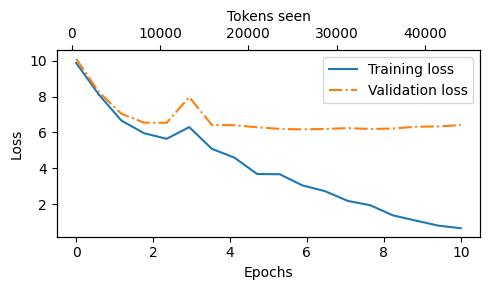

In [48]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()  # Create a second x-axis for tokens seen
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for alignment
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Text Generation Strategies

In [49]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): D

In [50]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids("Every effort moves you,", tokenizer),
 max_new_tokens=25,
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you, through


**Temperature scaling** - It is just dividing logits by a numer greater than 0

Adding a probabilistic selection
process to the next-token generation task

In [51]:
vocab = {
 "closer": 0,
 "every": 1,
 "effort": 2,
 "forward": 3,
 "inches": 4,
 "moves": 5,
 "pizza": 6,
 "toward": 7,
 "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

assume the LLM is given the start context "every effort moves you" and generates the following next-token logits

In [52]:
next_token_logits = torch.tensor(
 [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

we convert the logits into
probabilities via the softmax function and obtain the token ID corresponding to the
generated token

In [53]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


To implement a probabilistic sampling process, we can now replace argmax with
the multinomial function

In [54]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


The multinomial
function samples the next token proportional to its probability score

In [55]:
def softmax_with_temperature(logits, temperature):
 scaled_logits = logits / temperature
 return torch.softmax(scaled_logits, dim=0)

Plotting the original probabilities alongside probabilities scaled with different temperature values

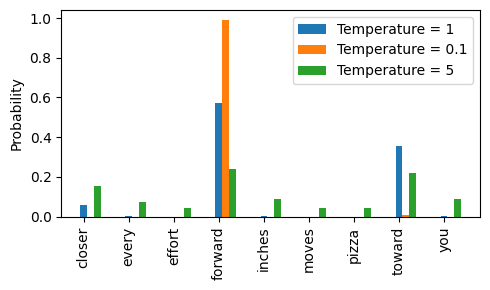

In [56]:
temperatures = [1, 0.1, 5] # original,lower and higher confidence
scaled_probas = [softmax_with_temperature(next_token_logits, T)
 for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
 rects = ax.bar(x + i * bar_width, scaled_probas[i],
  bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

**Top-k sampling**

we can restrict the
sampled tokens to the top-k most likely tokens and exclude all other tokens from the
selection process by masking their probability scores,

In [57]:
top_k = 3 # selection of the tokens with the largest logit values
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


set the logit values of tokens that are
below the lowest logit value within our top-three selection to negative infinity using where function

In [58]:
new_logits = torch.where(
 condition=next_token_logits < top_logits[-1], #identifies logits less than the minimum in top 3
 input=torch.tensor(float('-inf')), #assigns -inf to the lower logits
 other=next_token_logits #retains original logits for other tokens
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [59]:
topk_probas = torch.softmax(new_logits, dim=0)
print("Probabilities: ",topk_probas)

Probabilities:  tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


**Modifying text generation function** - Combining top-k and temperature scaling to text generation


In [60]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            if idx_next == eos_id:
                break

        idx = torch.cat((idx, idx_next), dim=1)  # Append the new token

    return idx  # Function returns after completing the loop

In [61]:
torch.manual_seed(123)
token_ids = generate(
 model=model,
 idx=text_to_token_ids("Every effort moves you", tokenizer),
 max_new_tokens=45,
 context_size=GPT_CONFIG_124M["context_length"],
 top_k=20,
 temperature=1.3
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know Jack Gisburn said a little it was such a good fellow enough--so it was no great surprise to Jack's resolve had gone a smile behind back the honour being _ up had again run over from Monte Carlo;


# Weight saving & Loading

Saving both the model and optimizer *state_dict* contents.

In [62]:
torch.save({
 "model_state_dict": model.state_dict(),
 "optimizer_state_dict": optimizer.state_dict(),
 },
 "model_and_optimizer.pth"
)

*state_dict()* - a dictionary mapping each layer to its parameters.
*model.pth* - the filename where the state_dict is saved, the .pth extension is a
convention for PyTorch files,

Mounting to drive so that I can import the model for finetuning

**Loading the saved model and optimizer states to GPTModel instance**

In [63]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

<ipython-input-63-2e32dcdb1060>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_location=device)


# Loading pretrained weights from OpenAI

In [64]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [65]:
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7b257819c050>)

In [66]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
 model_size="124M", models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


inspect the contents
of settings and params

In [67]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


The weights of the token embedding layer

In [68]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [69]:
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [70]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [71]:
NEW_CONFIG.update({"context_length": 1024})

In [72]:
NEW_CONFIG.update({"qkv_bias": True})

In [73]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dr

assign utility function that checks whether two tensors or arrays (left and
right) have the same dimensions or shape and returns the right tensor as trainable
PyTorch parameters

In [74]:
def assign(left, right):
 if left.shape != right.shape:
  raise ValueError(f"Shape mismatch. Left: {left.shape}, "
  "Right: {right.shape}"
  )
 return torch.nn.Parameter(torch.tensor(right))

**Loading OpenAI weights into GPT model code**

In [75]:
import numpy as np
def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
      (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight = assign(
      gpt.trf_blocks[b].att.W_query.weight, q_w.T)
    gpt.trf_blocks[b].att.W_key.weight = assign(
      gpt.trf_blocks[b].att.W_key.weight, k_w.T)
    gpt.trf_blocks[b].att.W_value.weight = assign(
      gpt.trf_blocks[b].att.W_value.weight, v_w.T)

    q_b, k_b, v_b = np.split(
      (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.bias = assign(
      gpt.trf_blocks[b].att.W_query.bias, q_b)
    gpt.trf_blocks[b].att.W_key.bias = assign(
      gpt.trf_blocks[b].att.W_key.bias, k_b)
    gpt.trf_blocks[b].att.W_value.bias = assign(
      gpt.trf_blocks[b].att.W_value.bias, v_b)

    gpt.trf_blocks[b].att.out_proj.weight = assign(
      gpt.trf_blocks[b].att.out_proj.weight,
      params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(
      gpt.trf_blocks[b].att.out_proj.bias,
      params["blocks"][b]["attn"]["c_proj"]["b"])

    gpt.trf_blocks[b].ff.layers[0].weight = assign(
      gpt.trf_blocks[b].ff.layers[0].weight,
      params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(
      gpt.trf_blocks[b].ff.layers[0].bias,
      params["blocks"][b]["mlp"]["c_fc"]["b"])

    gpt.trf_blocks[b].ff.layers[2].weight = assign(
      gpt.trf_blocks[b].ff.layers[2].weight,
      params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(
      gpt.trf_blocks[b].ff.layers[2].bias,
      params["blocks"][b]["mlp"]["c_proj"]["b"])

    gpt.trf_blocks[b].norm1.scale = assign(
      gpt.trf_blocks[b].norm1.scale,
      params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
      gpt.trf_blocks[b].norm1.shift,
      params["blocks"][b]["ln_1"]["b"])

  gpt.trf_blocks[b].norm2.scale = assign(
    gpt.trf_blocks[b].norm2.scale,
    params["blocks"][b]["ln_2"]["g"])
  gpt.trf_blocks[b].norm2.shift = assign(
    gpt.trf_blocks[b].norm2.shift,
    params["blocks"][b]["ln_2"]["b"])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [76]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dr

In [77]:
torch.manual_seed(123)
token_ids = generate(
 model=gpt,
 idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
 max_new_tokens=30,
 context_size=NEW_CONFIG["context_length"],
 top_k=50,
 temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as as the A the the many the ( the that. - of. a
 an it at more you ( a I you the one a of


# Fine Tuning

In [78]:
import urllib.request
import zipfile
import os
from pathlib import Path
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
def download_and_unzip_spam_data(
 url, zip_path, extracted_path, data_file_path):
 if data_file_path.exists():
  print(f"{data_file_path} already exists. Skipping download "
  "and extraction."
  )
  return

with urllib.request.urlopen(url) as response: #Download File
 with open(zip_path, "wb") as out_file:
  out_file.write(response.read())

 with zipfile.ZipFile(zip_path, "r") as zip_ref: # Unzips the file
  zip_ref.extractall(extracted_path)

 original_file_path = Path(extracted_path) / "SMSSpamCollection"
 os.rename(original_file_path, data_file_path)  #Adds a .tsv extension
 print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv
sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [79]:
import pandas as pd
df = pd.read_csv(
 data_file_path, sep="\t", header=None, names=["Label", "Text"]
)

print(df)

     Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [80]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [81]:
def create_balanced_dataset(df):
 num_spam = df[df["Label"] == "spam"].shape[0] # Counts spam instances
 ham_subset = df[df["Label"] == "ham"].sample(
 num_spam, random_state=123
 )

 balanced_df = pd.concat([
 ham_subset, df[df["Label"] == "spam"]
 ])
 return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [82]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [83]:
def random_split(df, train_frac, validation_frac):

 df = df.sample(
 frac=1, random_state=123
 ).reset_index(drop=True) #Shuffles the entire dataframe
 train_end = int(len(df) * train_frac) #Calculate split indices
 validation_end = train_end + int(len(df) * validation_frac)

 #Split dataframe
 train_df = df[:train_end]
 validation_df = df[train_end:validation_end]
 test_df = df[validation_end:]
 return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(
 balanced_df, 0.7, 0.1)

In [84]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [85]:
!pip install tiktoken

In [86]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [87]:
import torch
from torch.utils.data import Dataset

import pandas as pd

In [88]:
class SpamDataset(Dataset):
 def __init__(self, csv_file, tokenizer, max_length=None,
 pad_token_id=50256):
  self.data = pd.read_csv(csv_file)

 #Pretokenizes text
  self.encoded_texts = [
  tokenizer.encode(text) for text in self.data["Text"]
  ]

  if max_length is None:
    self.max_length = self._longest_encoded_length()
  else:
    self.max_length = max_length

  #Truncates sequences if they are longer than max length
  self.encoded_texts = [
  encoded_text[:self.max_length]
  for encoded_text in self.encoded_texts
  ]

  self.encoded_texts = [
    encoded_text + [pad_token_id] *
    (self.max_length - len(encoded_text))
    for encoded_text in self.encoded_texts
    ]

 def __getitem__(self, index):
  encoded = self.encoded_texts[index]
  label = self.data.iloc[index]["Label"]
  return (
    torch.tensor(encoded, dtype=torch.long),
    torch.tensor(label, dtype=torch.long)
    )

 def __len__(self):
  return len(self.data)

 def _longest_encoded_length(self):
  max_length = 0
  for encoded_text in self.encoded_texts:
    encoded_length = len(encoded_text)
    if encoded_length > max_length:
      max_length = encoded_length
  return max_length

In [89]:
train_dataset = SpamDataset(
 csv_file="train.csv",
 max_length=None,
 tokenizer=tokenizer
)

In [90]:
print(train_dataset.max_length)

120


In [91]:
val_dataset = SpamDataset(
 csv_file="validation.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)
test_dataset = SpamDataset(
 csv_file="test.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)

In [92]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(
 dataset=train_dataset,
 batch_size=batch_size,
 shuffle=True,
 num_workers=num_workers,
 drop_last=True,
)
val_loader = DataLoader(
 dataset=val_dataset,
 batch_size=batch_size,
 num_workers=num_workers,
 drop_last=False,
)
test_loader = DataLoader(
 dataset=test_dataset,
 batch_size=batch_size,
 num_workers=num_workers,
 drop_last=False,
)

In [93]:
for input_batch, target_batch in train_loader:
 pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [94]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


**Initializing pretrained weights**

In [95]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [96]:
BASE_CONFIG = {
 "vocab_size": 50257,
 "context_length": 1024,
 "drop_rate": 0.0,
 "qkv_bias": True
}
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [97]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
 model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.0, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dr

In [98]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(text_1, tokenizer),
 max_new_tokens=25,
 context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you the


In [99]:
text_2 = (
 "Is the following text 'spam'? Answer with 'yes' or 'no':"
 " 'You are a winner you have been specially"
 " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(text_2, tokenizer),
 max_new_tokens=23,
 context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' the


**Adding classification head**

Model Architecture

In [100]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.0, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dr

Freeze the model

In [101]:
for param in model.parameters():
 param.requires_grad = False

**Adding a classification layer**

In [102]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
 in_features=BASE_CONFIG["emb_dim"],
 out_features=num_classes
)

make the final LayerNorm and last transformer block trainable

In [102]:
for param in model.trf_blocks[-1].parameters():
 param.requires_grad = True
for param in model.final_norm.parameters():
 param.requires_grad = True

In [103]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


pass the encoded token IDs to the model

In [105]:
with torch.no_grad():
 outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[0.3708, 1.2060],
         [0.2238, 1.4616],
         [0.2839, 1.4423],
         [0.2767, 1.3516]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [106]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[0.2767, 1.3516]])


last token in a sequence accumulates the most information since it is the only token with access to data from all the
previous tokens. Therefore, in our spam classification task, we focus on this last token
during the fine-tuning process.